Preprocess archive.zip

In [ ]:
import zipfile
import pandas as pd
import os

# create "data" folder
if not os.path.exists("data/"):
    os.makedirs("data/")

# extract archive.zip
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    i = 1
    for file_name in zip_ref.namelist():
        print(f"Extracting files [{i}/22]")
        zip_ref.extract(file_name, "data/")
        i += 1

# convert csv files to json files
i = 1
for file_name in os.listdir("data/"):
    if file_name.endswith(".csv"):
        print(f"Converting csv files to json [{i}/11]")
        csv_file = os.path.join("data", file_name)
        df = pd.read_csv(csv_file)
        df['tags'] = df['tags'].str.split("|")
        df['country'] = file_name[:2]
        json_file = os.path.splitext(csv_file)[0] + ".json"
        df.to_json(json_file, orient='records')
        os.remove(csv_file)
        i += 1

print("Done.")

Import libraries

In [1]:
import pymongo
import json
import os
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import numpy as np
import pandas as pd


Connect to MongoDB

In [2]:
client = pymongo.MongoClient("localhost", 27017)

Create database and collections

In [3]:
db = client["my_db"]
collection_cat = db['youtube_categories']
collection_vids = db['videos_data']

Insert json files to collections

In [4]:
# Iterate through the json files in the "data" directory
for filename in os.listdir("data/"):
    print(f'Inserting {filename}...')
    filename = 'data/' + filename
    with open(filename, 'r') as f:
        data = json.load(f)
    if 'category' in filename:

        collection_cat.insert_many(data["items"])
        
    else:
        # Insert the json documents into the collection
        
        collection_vids.insert_many(data)

print("Done.")

Inserting RU_youtube_trending_data.json...
Inserting GB_youtube_trending_data.json...
Inserting US_youtube_trending_data.json...
Inserting FR_youtube_trending_data.json...
Inserting CA_youtube_trending_data.json...
Inserting MX_youtube_trending_data.json...
Inserting FR_category_id.json...
Inserting JP_youtube_trending_data.json...
Inserting JP_category_id.json...
Inserting IN_category_id.json...
Inserting BR_category_id.json...
Inserting BR_youtube_trending_data.json...
Inserting IN_youtube_trending_data.json...
Inserting US_category_id.json...
Inserting DE_youtube_trending_data.json...
Inserting KR_category_id.json...
Inserting GB_category_id.json...
Inserting KR_youtube_trending_data.json...
Inserting RU_category_id.json...
Inserting DE_category_id.json...
Inserting CA_category_id.json...
Inserting MX_category_id.json...
Done.


### Task 1: Analysis of the channel "Saturday Night Live". [GB]

In [5]:
result = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'country': 'GB', 
            'channelTitle': 'Saturday Night Live'
        }
    }, {
        '$sort': {
            'trending_date': -1
        }
    }, {
        '$group': {
            '_id': '$title', 
            'likes': {
                '$first': '$likes'
            }, 
            'dislikes': {
                '$first': '$dislikes'
            }, 
            'views': {
                '$first': '$view_count'
            }, 
            'publishedAt': {
                '$first': '$publishedAt'
            }
        }
    }, {
        '$sort': {
            'publishedAt': 1
        }
    }, {
        '$project': {
            '_id': 1, 
            'likes': 1, 
            'dislikes': 1, 
            'views': 1, 
            'publishedAt': {
                '$dateToString': {
                    'format': '%Y-%m-%d', 
                    'date': {
                        '$convert': {
                            'input': '$publishedAt', 
                            'to': 'date'
                        }
                    }
                }
            }
        }
    }
])

views = []
publishedAt = []
for item in result:
    publishedAt.append(item['publishedAt'])
    views.append(item['views'])

### Task 1: Visualization

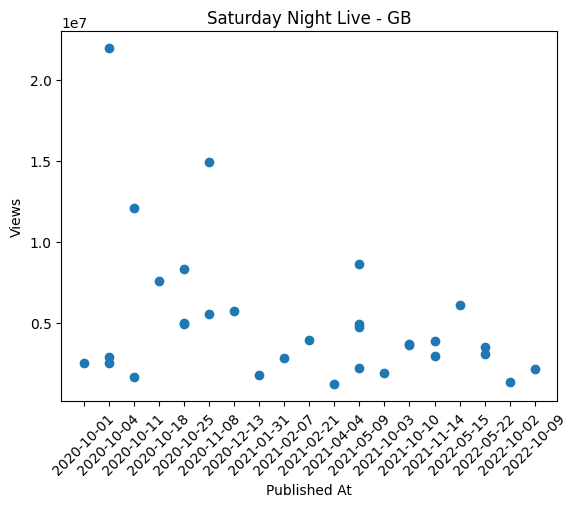

In [6]:


plt.scatter(publishedAt, views)
plt.xlabel('Published At')
plt.ylabel('Views')
plt.xticks(rotation=45)
plt.title("Saturday Night Live - GB")
plt.show()


### Task 2: How many tags are used per video? [GB]

In [7]:
result = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'country': 'GB', 
            'tags': {
                '$nin': [
                    '[None]'
                ]
            }, 
            'view_count': {
                '$gt': 0
            }
        }
    }, {
        '$sort': {
            'trending_date': -1
        }
    }, {
        '$group': {
            '_id': '$title', 
            'avg_num_tags': {
                '$avg': {
                    '$size': '$tags'
                }
            }, 
            'views': {
                '$first': '$view_count'
            }, 
            'video_id': {
                '$first': '$video_id'
            }
        }
    }, {
        '$sort': {
            'views': -1
        }
    }, {
        '$project': {
            '_id': 0, 
            'avg_num_tags': 1, 
            'video_id': 1, 
            'views': 1
        }
    }
])

views = []
avg_num_tags = []
for item in result:
    avg_num_tags.append(item['avg_num_tags'])
    views.append(item['views'])

### Task 2: Visualize

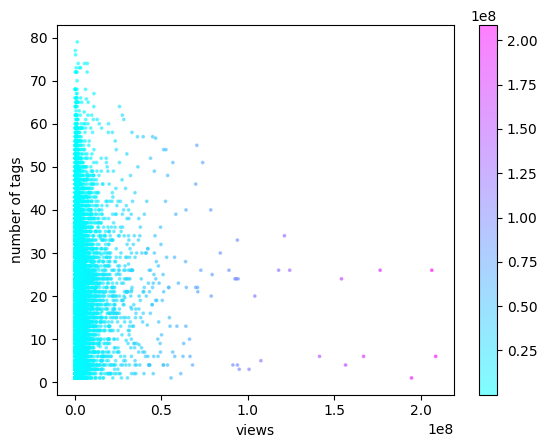

In [8]:
plt.scatter(views, avg_num_tags, s=3, alpha=0.5, c=views, cmap='cool')
plt.colorbar()
plt.xlabel('views')
plt.ylabel('average number of tags')
plt.show()

### Task 3:

In [11]:
result = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'tags': {
                '$nin': [
                    '[None]'
                ]
            }
        }
    }, {
        '$group': {
            '_id': {
                'video_id': '$video_id', 
                'country': '$country'
            }, 
            'num_tags': {
                '$push': '$tags'
            }, 
            'view_count': {
                '$max': '$view_count'
            }
        }
    }, {
        '$unwind': {
            'path': '$num_tags'
        }
    }, {
        '$unwind': {
            'path': '$num_tags'
        }
    }, {
        '$group': {
            '_id': '$_id', 
            'num_tags': {
                '$addToSet': '$num_tags'
            }, 
            'view_count': {
                '$first': '$view_count'
            }
        }
    }, {
        '$group': {
            '_id': '$_id.country', 
            'avg_tags_per_video': {
                '$avg': {
                    '$size': '$num_tags'
                }
            }, 
            'avg_views_per_video': {
                '$avg': '$view_count'
            }
        }
    }, {
        '$project': {
            'avg_tags_per_video': {
                '$round': [
                    '$avg_tags_per_video', 2
                ]
            }, 
            'avg_views_per_video': {
                '$round': [
                    '$avg_views_per_video', 2
                ]
            }
        }
    }
])

country = []
avg_tags_per_video = []
avg_views_per_video = []

for item in result:
    country.append(item['_id'])
    avg_tags_per_video.append(item['avg_tags_per_video'])
    avg_views_per_video.append(item['avg_views_per_video'])

### Task 3: Visualization

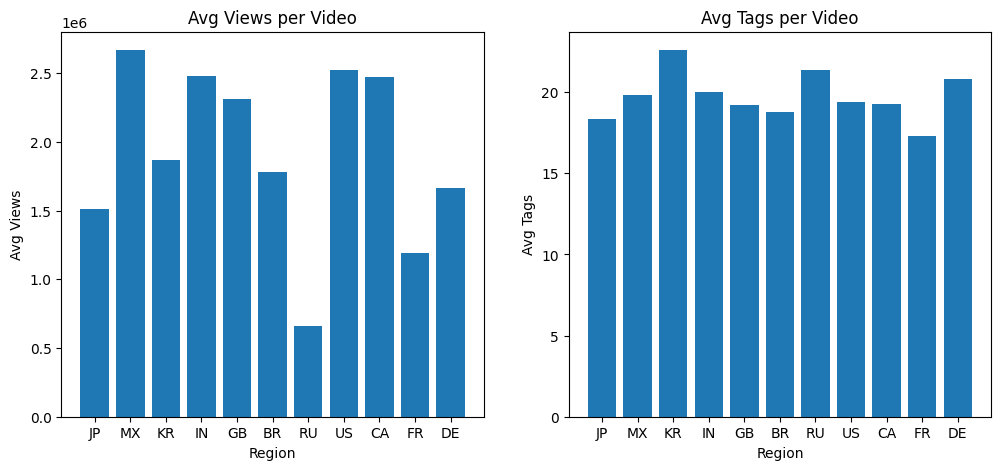

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax1.bar(country, avg_views_per_video)
ax1.set_title('Avg Views per Video')
ax1.set_xlabel('Region')
ax1.set_ylabel('Avg Views')

# Plot the avg tags data on ax2
ax2.bar(country, avg_tags_per_video)
ax2.set_title('Avg Tags per Video')
ax2.set_xlabel('Region')
ax2.set_ylabel('Avg Tags')

# Show the plot
plt.show()

### Task 4
With the first query we get the desired results, but we don't need all of these for the visualization, so after the first query, we are executing another one.

#### Task 4:
This query gets all the results:

```python .noeval
result = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'country': {
                '$in': [
                    'US', 'GB'
                ]
            }
        }
    }, {
        '$group': {
            '_id': {
                'country': '$country'
            }, 
            'tags': {
                '$addToSet': '$tags'
            }
        }
    }, {
        '$unwind': {
            'path': '$tags'
        }
    }, {
        '$unwind': {
            'path': '$tags'
        }
    }, {
        '$group': {
            '_id': {
                'tag': '$tags', 
                'country': '$_id.country'
            }, 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }, {
        '$project': {
            'count': 1, 
            '_id': 0, 
            'country': '$_id.country', 
            'tag': '$_id.tag'
        }
    }
])
```

#### Task 4: Top-20 tags per region
With this query we get the top 200 tags, and then we keep the top-20 for each country so we can visualize these results:

In [20]:
result = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'country': {
                '$in': [
                    'US', 'GB'
                ]
            }
        }
    }, {
        '$group': {
            '_id': {
                'country': '$country'
            }, 
            'tags': {
                '$addToSet': '$tags'
            }
        }
    }, {
        '$unwind': {
            'path': '$tags'
        }
    }, {
        '$unwind': {
            'path': '$tags'
        }
    }, {
        '$group': {
            '_id': {
                'tag': '$tags', 
                'country': '$_id.country'
            }, 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }, {
        '$limit': 200
    }, {
        '$project': {
            'count': 1, 
            '_id': 0, 
            'country': '$_id.country', 
            'tag': '$_id.tag'
        }
    }
])

counts = []
tags = []
countries = []

for item in result:
    counts.append(item['count'])
    tags.append(item['tag'])
    countries.append(item['country'])

tags_US = [tags[i] for i in range(len(countries)) if countries[i] == "US"][:20]
counts_US = [counts[i] for i in range(len(countries)) if countries[i] == "US"][:20]
tags_GB = [tags[i] for i in range(len(countries)) if countries[i] == "GB"][:20]
counts_GB = [counts[i] for i in range(len(countries)) if countries[i] == "GB"][:20]



del countries
del counts
del tags

### Task 4: Visualize

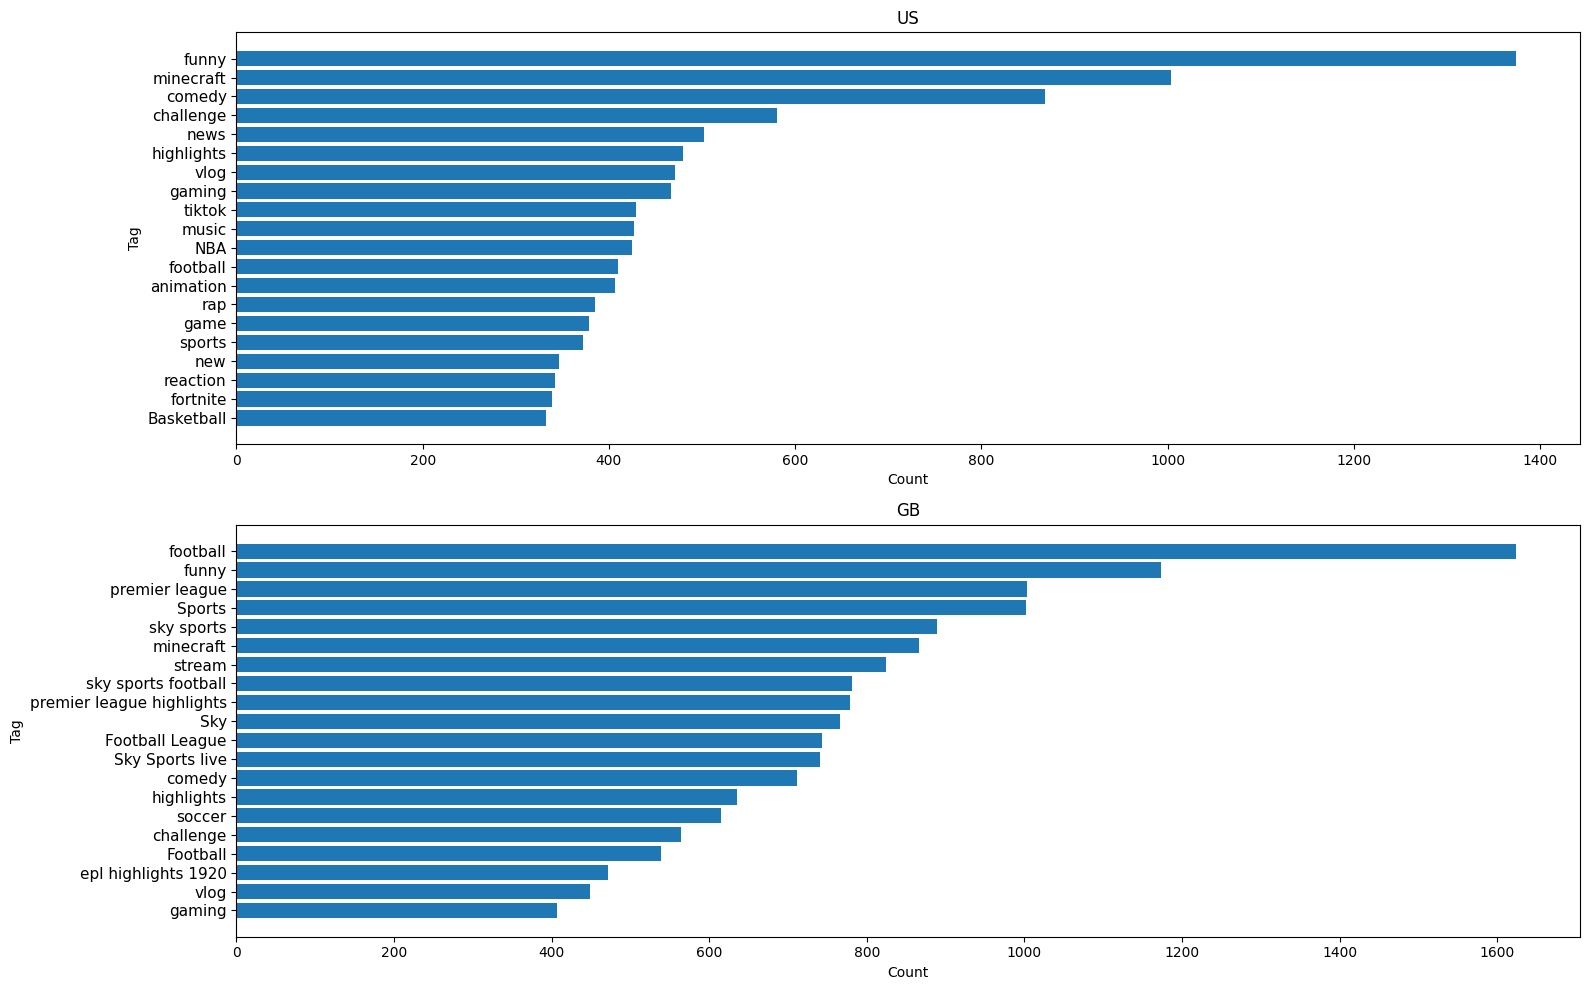

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
ax1.barh(tags_US, counts_US)
ax1.set_xlabel('Count')
ax1.set_ylabel('Tag')
ax1.invert_yaxis()
ax1.yaxis.set_tick_params(labelsize=11)
ax1.set_title("US")

ax2.barh(tags_GB, counts_GB)
ax2.set_xlabel('Count')
ax2.set_ylabel('Tag')
ax2.invert_yaxis()
ax2.yaxis.set_tick_params(labelsize=11)
ax2.set_title("GB")

plt.tight_layout()
plt.show()

### Task 5:

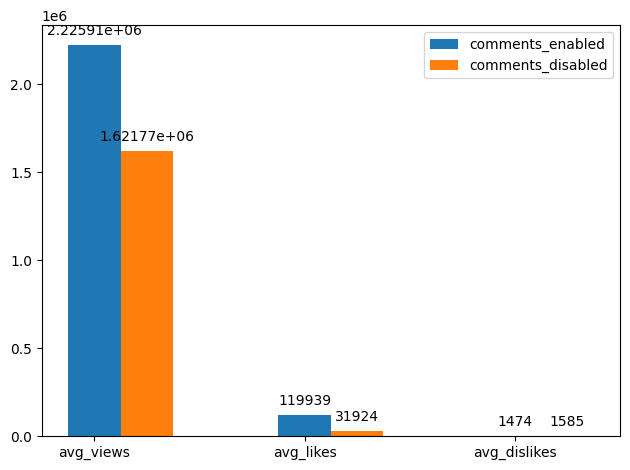

In [17]:
result1 = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'country': 'GB', 
            'comments_disabled': True
        }
    }, {
        '$group': {
            '_id': None, 
            'avg_views': {
                '$avg': '$view_count'
            }, 
            'avg_likes': {
                '$avg': '$likes'
            }, 
            'avg_dislikes': {
                '$avg': '$dislikes'
            }
        }
    }, {
        '$project': {
            '_id': 0, 
            'avg_views': {
                '$trunc': [
                    '$avg_views', 2
                ]
            }, 
            'avg_likes': {
                '$trunc': [
                    '$avg_likes', 2
                ]
            }, 
            'avg_dislikes': {
                '$trunc': [
                    '$avg_dislikes', 2
                ]
            }
        }
    }
])


result2 = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'country': 'GB', 
            'comments_disabled': False
        }
    }, {
        '$group': {
            '_id': None, 
            'avg_views': {
                '$avg': '$view_count'
            }, 
            'avg_likes': {
                '$avg': '$likes'
            }, 
            'avg_dislikes': {
                '$avg': '$dislikes'
            }
        }
    }, {
        '$project': {
            '_id': 0, 
            'avg_views': {
                '$trunc': [
                    '$avg_views', 2
                ]
            }, 
            'avg_likes': {
                '$trunc': [
                    '$avg_likes', 2
                ]
            }, 
            'avg_dislikes': {
                '$trunc': [
                    '$avg_dislikes', 2
                ]
            }
        }
    }
])



comments_disabled = []
comments_enabled = []

for item in result1:
    comments_disabled.append(round(item['avg_views']))
    comments_disabled.append(round(item['avg_likes']))
    comments_disabled.append(round(item['avg_dislikes']))

for item in result2:
    comments_enabled.append(round(item['avg_views']))
    comments_enabled.append(round(item['avg_likes']))
    comments_enabled.append(round(item['avg_dislikes']))


labels = ['avg_views', 'avg_likes', 'avg_dislikes']
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x + 0.00, comments_enabled, width, label='comments_enabled')
rects2 = ax.bar(x + 0.25, comments_disabled, width, label='comments_disabled')


ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=5)
ax.bar_label(rects2, padding=5)

fig.tight_layout()

plt.show()

### Task 6:

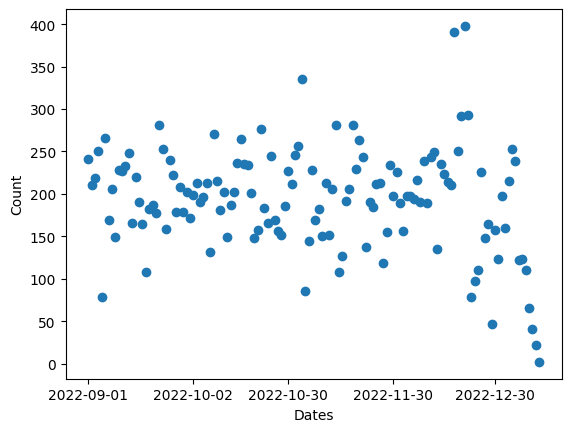

In [18]:
result = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'country': 'GB'
        }
    }, {
        '$project': {
            'date': {
                '$dateToString': {
                    'format': '%Y-%m-%d', 
                    'date': {
                        '$convert': {
                            'input': '$publishedAt', 
                            'to': 'date'
                        }
                    }
                }
            }
        }
    }, {
        '$match': {
            'date': {
                '$gte': '2022-09-01'
            }
        }
    }, {
        '$group': {
            '_id': '$date', 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            '_id': 1
        }
    }, {
        '$project': {
            'date': '$_id', 
            'count': 1, 
            '_id': 0
        }
    }
])

# 'result' is an iterator object?
x_values = []
y_values = []
for item in result:
    x_values.append(item['date'])
    y_values.append(item['count'])

plt.scatter(x_values, y_values)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlabel('Dates')
plt.ylabel('Count')
plt.show()

### Bonus task: How many days did it take for videos to enter the trending list?

In [20]:
result = client['my_db']['videos_data'].aggregate([
    {
        '$match': {
            'country': {
                '$in': [
                    'US', 'GB'
                ]
            }
        }
    }, {
        '$group': {
            '_id': '$video_id', 
            'first_trending_date': {
                '$min': '$trending_date'
            }, 
            'published_date': {
                '$min': '$publishedAt'
            }
        }
    }, {
        '$project': {
            'publishedAt': {
                '$convert': {
                    'input': '$published_date', 
                    'to': 'date'
                }
            }, 
            'trending_date': {
                '$convert': {
                    'input': '$first_trending_date', 
                    'to': 'date'
                }
            }
        }
    }, {
        '$project': {
            '_id': 0, 
            'days_to_trend': {
                '$floor': {
                    '$divide': [
                        {
                            '$subtract': [
                                '$trending_date', '$publishedAt'
                            ]
                        }, 1000 * 60 * 60 * 24
                    ]
                }
            }
        }
    }
])

days_to_trend = [x['days_to_trend'] if x['days_to_trend'] > 0 else 0 for x in result]



Bonus task 1: Results

In [22]:
mean = np.mean(days_to_trend)
median = np.median(days_to_trend)
std = np.std(days_to_trend)
max = np.max(days_to_trend)

print("Mean: ", mean)
print("Median: ", median)
print("Standard deviation: ", std)
print("Max: ", max)

Mean:  0.5358409925517127
Median:  0.0
Standard deviation:  1.229557712349709
Max:  30.0
